In [1]:
import transformers 
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns


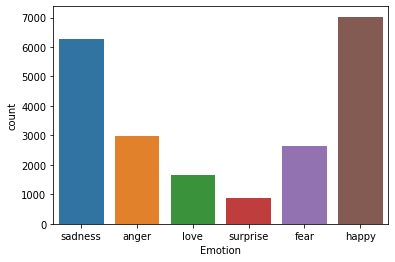

In [2]:
df = pd.read_csv("Emotion_final.csv")
sns.countplot(df.Emotion)

#### shuffle dataframe

In [3]:
for i in range(100):
    df = df.sample(frac = 1)
    df = df.sample(frac = 1)
    df = df.sample(frac = 1)
    df = df.sample(frac = 1)
    df = df.sample(frac = 1)
print(df)

                                                    Text  Emotion
8084   i feel so unimportant right now like i am not ...  sadness
18464  i get why she is concerned because i have been...  sadness
15586  i was feeling bouncy so i added a few of my go...    happy
2223   i feel drained yet so excited for her and her ...  sadness
1783   i feel im being violent is i say no im not goi...    anger
...                                                  ...      ...
16593  i cant tell you how many times in the four mon...     love
11752  i guess im just really feeling the heat lately...    happy
8622   i feel like i m murdering innocent brain cells...    happy
8886   i feel i am so strong enough to take this pain...    happy
5655   at a certain situation i felt myself neglected...    anger

[21459 rows x 2 columns]


In [4]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Emotion"] = label_encoder.fit_transform(df["Emotion"])
print(df)

                                                    Text  Emotion
8084   i feel so unimportant right now like i am not ...        4
18464  i get why she is concerned because i have been...        4
15586  i was feeling bouncy so i added a few of my go...        2
2223   i feel drained yet so excited for her and her ...        4
1783   i feel im being violent is i say no im not goi...        0
...                                                  ...      ...
16593  i cant tell you how many times in the four mon...        3
11752  i guess im just really feeling the heat lately...        2
8622   i feel like i m murdering innocent brain cells...        2
8886   i feel i am so strong enough to take this pain...        2
5655   at a certain situation i felt myself neglected...        0

[21459 rows x 2 columns]


In [5]:
print("SHAPE::",df.shape)

SHAPE:: (21459, 2)


In [6]:
class_name = ['sadness','anger','love','surprise','fear','happy']

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cpu')

In [9]:
PRE_TRAINED_MODEL_NAME = 'roberta-base'

In [10]:
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [11]:
roberta_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|██████████████████████████████████████████████████████████████████████████| 21459/21459 [00:09<00:00, 2236.78it/s]


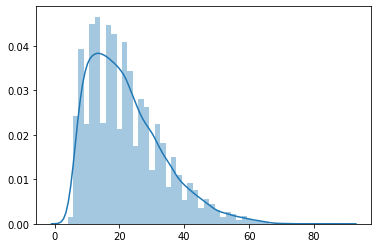

In [12]:
from tqdm import tqdm
token_lens = []
for txt in tqdm(df.Text):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.distplot(token_lens)

In [13]:
from torch.utils.data import Dataset, DataLoader
class ReviewDataset(Dataset):
    def __init__(self,reviews,targets,tokenizer,max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

In [14]:
size=len(df)
df_test = df[0:int(size/8)]
df_val = df[int(size/8):int(size/4)]
df_train = df[int(size/4):size]

In [15]:
df_train.shape, df_val.shape, df_test.shape


((16095, 2), (2682, 2), (2682, 2))

In [16]:
print(df)

                                                    Text  Emotion
8084   i feel so unimportant right now like i am not ...        4
18464  i get why she is concerned because i have been...        4
15586  i was feeling bouncy so i added a few of my go...        2
2223   i feel drained yet so excited for her and her ...        4
1783   i feel im being violent is i say no im not goi...        0
...                                                  ...      ...
16593  i cant tell you how many times in the four mon...        3
11752  i guess im just really feeling the heat lately...        2
8622   i feel like i m murdering innocent brain cells...        2
8886   i feel i am so strong enough to take this pain...        2
5655   at a certain situation i felt myself neglected...        0

[21459 rows x 2 columns]


In [17]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_train.Emotion.values),
                                                 df_train.Emotion.values)

In [18]:
class_weights

array([1.20778928, 1.33723829, 0.50833807, 2.17206478, 0.56953291,
       4.15247678])

In [19]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = ReviewDataset(
        reviews = df.Text.to_numpy(), 
        targets = df.Emotion.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=0)

In [20]:
MAX_LEN=25
BATCH_SIZE = 5
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [21]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.4)
        #self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
        self.out1 = nn.Linear(self.roberta.config.hidden_size, 128)
        self.drop1 = nn.Dropout(p=0.4)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, n_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.roberta(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        output= pooled_output[0][:,0]
        output = self.drop(output)
        #output = self.relu(pooled_output)
        #hidden_state = pooled_output[0]
        #output = hidden_state[:,0]
        #output = self.drop(output)
        output = self.out1(output)
        output = self.relu(output)
        output = self.drop1(output)
        return self.out(output)

In [22]:
model = SentimentClassifier(len(class_name))
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
#class_weights = torch.FloatTensor(class_weights).to(device)
#weight=class_weights
loss_fn = nn.CrossEntropyLoss().to(device)

C:\Users\Fatemeh\anaconda3\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [24]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    print(data_loader)
    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------


C:\Users\Fatemeh\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss 1.607892711568449 accuracy 0.320161540851196
Val   loss 1.6003725388862566 accuracy 0.32177479492915734

Epoch 2/5
----------
Train loss 1.5751384786749967 accuracy 0.34855545200372784
Val   loss 1.3762130407092736 accuracy 0.5044742729306487

Epoch 3/5
----------
Train loss 1.2281783336380618 accuracy 0.5632805219012116
Val   loss 0.9873808196137072 accuracy 0.65137956748695

Epoch 4/5
----------
Train loss 0.8657820245367366 accuracy 0.736067101584343
Val   loss 0.8760064805977504 accuracy 0.7777777777777778

Epoch 5/5
----------
Train loss 0.735626225806738 accuracy 0.7958372165268717
Val   loss 0.7711976927720718 accuracy 0.8102162565249813



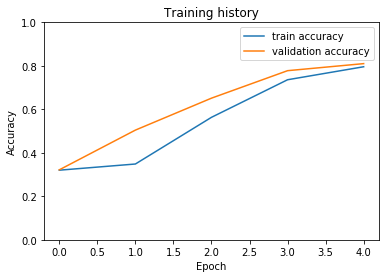

In [27]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [33]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.808351976137211

In [34]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [30]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [31]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

     sadness       0.87      0.77      0.82       397
       anger       0.75      0.80      0.77       309
        love       0.88      0.86      0.87       889
    surprise       0.66      0.56      0.61       200
        fear       0.77      0.92      0.84       776
       happy       0.74      0.18      0.29       111

    accuracy                           0.81      2682
   macro avg       0.78      0.68      0.70      2682
weighted avg       0.81      0.81      0.80      2682



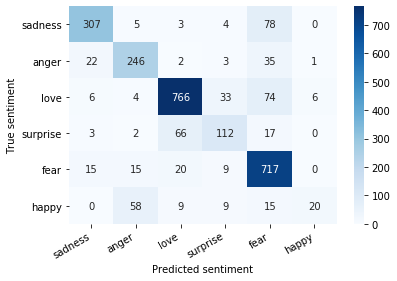

In [32]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)